This is my version of Jorge M's local circuit in Python. Sean Froudist-Walsh DEC 2018


In [58]:
# let's get what we need together
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
import scipy.io as sio
import brian2
import PyDSTool as dst
from datetime import datetime


Define the function that transforms input current to changes in firing rate for excitatory neurons (Abbott and Chance, 2005). 
<br>
$$r_E = \frac{aI_{syn,E} - b}{1 - e^{-d(aI_{syn,E} - b)}} $$

Update the firing rates of the interneurons using a threshold linear input/output function
$$ \begin{cases}
  r_I = \frac{1}{g_2}(c_II_{syn,I} - c_0) + r_0 & \text{for } r_I\ge 0\\    
  r_I = 0     & \text{otherwise }  
\end{cases} $$


In [59]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        a = parameters['a_E']
        b = parameters['b_E']
        d = parameters['d_E']
        return np.divide((a*input_current - b),(1 - np.exp(-d*(a*input_current - b))))
    if population_type == 'I':
        c_I = parameters['c_I']
        g_2 = parameters['g_2']
        r_0 = parameters['r0_I']
        c_0 = parameters['c_0']
        
        r = np.maximum((1/g_2)*(c_I*input_current - c_0) + r_0,0)

        return r

        # NOTE: using python broadcasting for ones subtraction, so should work for multi-area case too

Define the NMDA derivative
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + (1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [60]:
def NMDA_deriv(S_NMDA_prev,rate_now,parameters):
    
    return -S_NMDA_prev/parameters['tau_NMDA'] + parameters['gam']*(1 - S_NMDA_prev)*rate_now

Define the GABA derivative
<br>
$$ \frac{dS_{GABA}}{dt} = -\frac{S_{GABA}}{\tau_{GABA}} + \gamma_Ir_I$$
(Wong & Wang, 2006)

In [61]:
def GABA_deriv(S_GABA_prev,rate_now,parameters):
    
    return -S_GABA_prev/parameters['tau_GABA'] + parameters['gammai']*rate_now

Load in anatomical data

In [62]:
subgraph_data = sio.loadmat('subgraphData30.mat')

# fln = subgraph_data['fln']
# sln = subgraph_data['sln']
hierarchy = subgraph_data['hierVals']

area_list = ['V1','V2','V4','DP','MT','8m','5','8l','2','TEO','F1','STPc','7A','46d','10','9/46v','9/46d','F5','TEpd','PBr','7m','LIP','F2','7B','ProM','STPi','F7','8b','STPr','24c','X1','X2','X3','X4','X5']
area_column_list  = ['from '+ mystring for mystring in area_list]
area_row_list  = ['to '+ mystring for mystring in area_list]

# df_fln = pandas.DataFrame(fln , columns=area_column_list, index=area_row_list)



In [63]:

parameters = {}
parameters.update({'SF1': 0.5, # Jorge M scaling factor to keep rates in check
                    'SF2': 2})    # Jorge M scaling factor to keep rates in check
                   
parameters.update({ # Time constants
                    'tau_NMDA': 0.06   * brian2.second,    # s 
                    'tau_GABA': 0.005  * brian2.second,    # s 
                    'tau_AMPA': 0.002  * brian2.second,    # s 
                    'tau_rates': 0.002 * brian2.second,    # s 
                    # f-I curve parameters - E populations
                    'a_E': 270. *parameters['SF1']  * brian2.Hz/brian2.nA,  # Hz/nA
                    'b_E': 108. *parameters['SF1']  * brian2.Hz,            # Hz
                    'd_E': 0.154*parameters['SF2']  * brian2.second,        # s
                    'gam': 0.641*parameters['SF2'],                         # unitless
                    # f-I curve parameters - I populations
                    'g_2': 1/(0.5*parameters['SF1']),                    # unitless
                    'c_I': 615  * brian2.Hz/brian2.nA,                 # Hz/nA
                    'c_0': 177  * brian2.Hz,                           # Hz
                    'gammai': parameters['SF2'],                       # unitless
                    # Local connectivity matrix strengths
                    # Strength of connections from E cells
                    'g_E_self': 0.21 * brian2.nA ,        # nA
                    'g_E_cross': 0.0107* brian2.nA,         # nA

                    # Strength of connections from I cells
                    'g_E_I':  -0.31    * brian2.nA,         # nA
                    'g_Iself': -0.12   * brian2.nA,         # nA
                    # John Murray's term
                    'J_plus': 0.2112   * brian2.nA,         # nA - Matches value in John Murray's thesis for g_E_self - g_E_cross
                    # Background inputs
                    'I0_E': 0.3294     * brian2.nA,         # nA
                    'I0_I': 0.26       * brian2.nA,         # nA
                    # Noise std dev
                    'std_noise': 0.00 * brian2.nA,         # nA      
                    # initial values
                    'r0_E': 5 * brian2.Hz,
                    'r0_I': 11*parameters['SF1'] * brian2.Hz
                        })      
parameters.update({ # Zetas
                    'zeta': parameters['c_I']*parameters['g_E_I']*parameters['tau_GABA']*parameters['gammai']\
                            /(parameters['g_2'] - parameters['g_Iself']*parameters['tau_GABA']*parameters['gammai']*parameters['c_I']),
                    'zeta2': 2*parameters['c_I']*parameters['tau_GABA']*parameters['gammai']*parameters['g_E_I']\
                            /(parameters['c_I']*parameters['tau_GABA']*parameters['gammai']*parameters['g_Iself'] - parameters['g_2']),
                        })    


######## LOCAL ########
J =  np.array([[0    , parameters['g_E_cross'], 0],
              [parameters['g_E_cross']    , 0,  0],
               [parameters['g_E_I'],parameters['g_E_I'],parameters['g_Iself'] ]]).T * brian2.amp
pops = ['E1','E2','I']
pops_column_list  = ['from '+ mystring for mystring in pops]
pops_row_list  = ['to '+ mystring for mystring in pops]

df_J = pandas.DataFrame(J , columns=pops_column_list, index=pops_row_list)

J_NMDA = J*((J>0).astype(np.int))
J_GABA = J*((J<0).astype(np.int))

######## HIERARCHY ########
#Scale the local E to E synapses to lie according to the hierarchy
hierachy_scaling_factor = 1# eta in Chaudhuri et al., 2015
hierarchy_min = 1 
# Add in a few extra higher regions to identify the bifurcation points
extra_hierarchy = np.arange(1.1,1.6,0.1)
extra_hierarchy.shape = (5,1)
hierarchy = np.concatenate((hierarchy,extra_hierarchy))
local_EE_gradient = hierarchy_min + hierachy_scaling_factor*hierarchy


# Scale the E to I synapses to lie along the hierarachy
local_IE_gradient = 0.5*(parameters['J_plus']-local_EE_gradient*parameters['g_E_self']-parameters['g_E_cross'])/(parameters['zeta']*brian2.nA)
parameters['g_I_E'] = np.max(local_IE_gradient) *brian2.nA      # nA
local_IE_gradient = local_IE_gradient/np.max(local_IE_gradient)


num_areas = hierarchy.shape[0]
num_pops  = J.shape[0]
num_E_pops = 2

# Choose initial values for rates and synapse variables
R0vec = np.array([parameters['r0_E'],parameters['r0_E'],parameters['r0_E']])
R0 = np.matlib.repmat(R0vec, num_areas, 1) * brian2.Hz
S_NMDA0 = 0*np.concatenate((np.ones((num_areas,2)),np.zeros((num_areas,num_pops-2))), axis=1)
S_GABA0 = 0*np.concatenate((np.zeros((num_areas,2)),np.ones((num_areas,num_pops-2))), axis=1)


# Choose stimulus and distractor strength
stim_strength = 0.3 * brian2.nA
distractor_strength = 0 * brian2.nA



In [64]:
# Set up simulation parameters
dt=0.5 * brian2.ms  # timestep 
trial_length=10000 * brian2.ms # trial length (s)
num_iterations = int(trial_length/dt)
time = np.arange(0, trial_length, dt)


# Preassign rate and synapse matrices
R = np.zeros((num_iterations,num_areas,num_pops)) * brian2.Hz
R[0,:,:] = R0
S_NMDA = np.zeros((num_iterations,num_areas,num_pops))
S_NMDA[0,:,:] = S_NMDA0
S_GABA = np.zeros((num_iterations,num_areas,num_pops))
S_GABA[0,:,:] = S_GABA0

# # Preassign external inputs
I_ext    = np.zeros((num_iterations,num_areas,num_pops)) * brian2.amp
stim_on    = 4 * brian2.second #s
stim_off   = 4.5 * brian2.second #s
distract_on  = 3.5 * brian2.second #s
distract_off = 4 * brian2.second #s

# Let's apply external stimulation to all disconnected areas, populations E1 & E2
I_ext[int(stim_on/dt):int(stim_off/dt),:,pops.index('E1')] = stim_strength
I_ext[int(distract_on/dt):int(distract_off/dt),:,pops.index('E2')] = distractor_strength

# Create matrices in which we can store the currents
I_local_nongrad_NMDA =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
I_local_grad_NMDA =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
I_local_GABA =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
I_soma_dend  =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
I_total      =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
I_exc_dend   = np.zeros((num_iterations,num_areas,num_E_pops)) * brian2.pA
I_inh_dend   = np.zeros((num_iterations,num_areas,num_E_pops)) * brian2.pA

# # Define background inputs
I_0 = np.zeros((num_areas,num_pops)) * brian2.pA
I_0[:,[pops.index('E1'),pops.index('E2')]] = parameters['I0_E']
I_0[:,pops.index('I')] = parameters['I0_I']

# Let's set up the noise. We will model the noise as an Ornstein-Uhlenbeck process.

# Gaussian noise. mean 0, std 1. Dims: timesteps, local populations, areas
eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_areas,num_pops ))

# prepare the right hand side of the above equation
noise_rhs = eta*((np.sqrt(parameters['tau_AMPA']*np.power(parameters['std_noise'],2))*np.sqrt(dt))/parameters['tau_AMPA'])
noise_rhs[:,:,2] = 0 # Jorge only put nosi
I_noise = np.zeros((num_areas , num_pops )) *brian2.pA



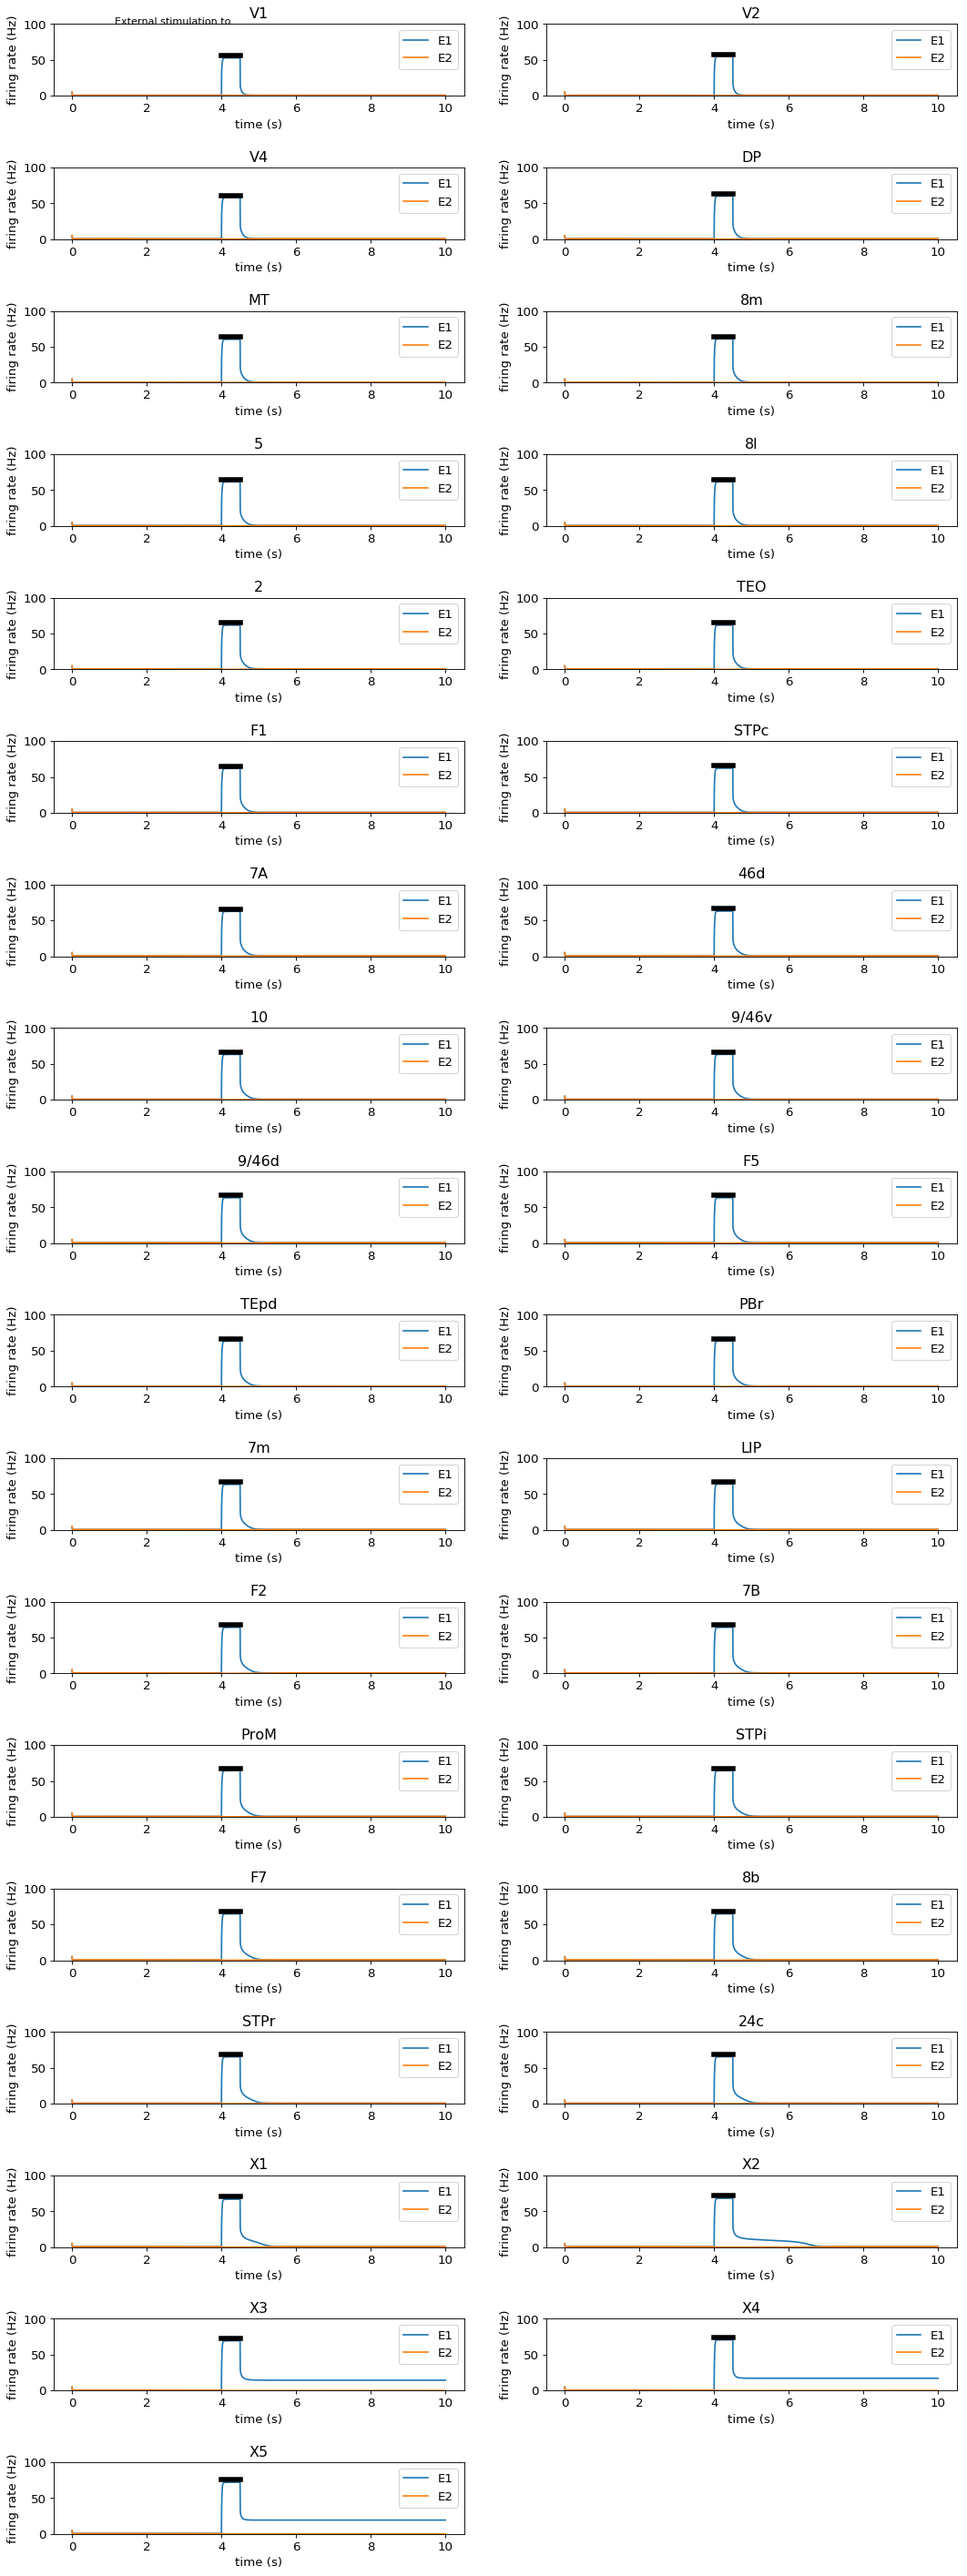

In [65]:
for i_t in range(1,num_iterations):
    
    # update noise - dims = num local pops x num areas
    I_noise = I_noise + -I_noise*(dt/parameters['tau_AMPA']) + noise_rhs[i_t-1,:,:]
    
    # local non-graded NMDA
    I_local_nongrad_NMDA[i_t-1,:,:] = J_NMDA.dot(S_NMDA[i_t-1,:,:].T).T

    # local non-graded NMDA
    # Note that Jorge only applies the hierarchy to self connections, hence we need to do this line-by-line
    I_local_grad_NMDA[i_t-1,:,0] = np.squeeze(local_EE_gradient)*parameters['g_E_self']*S_NMDA[i_t-1,:,0]
    I_local_grad_NMDA[i_t-1,:,1] = np.squeeze(local_EE_gradient)*parameters['g_E_self']*S_NMDA[i_t-1,:,1]

    # sum up all the local NMDA current onto I cells
    I_local_grad_NMDA[i_t-1,:,2]  = np.squeeze(local_IE_gradient)*parameters['g_I_E']*S_NMDA[i_t-1,:,0] + np.squeeze(local_IE_gradient)*parameters['g_I_E']*S_NMDA[i_t-1,:,1]

    # sum up all the local GABA current onto E and I cells
    I_local_GABA[i_t-1,:,:] = J_GABA.dot(S_GABA[i_t-1,:,:].T).T

    # Define total input current as sum of local NMDA & GABA inputs, with background and external currents, 
    # noise and long-range NMDA inputs
    I_total[i_t-1,:,:] = I_local_grad_NMDA[i_t-1,:,:] + I_local_nongrad_NMDA[i_t-1,:,:] + I_local_GABA[i_t-1,:,:] + I_0 + I_ext[i_t-1,:,:] + I_noise
    
    # Update the firing rates of the two excitatory populations.
    R[i_t,:,:2] = R[i_t-1,:,:2] + dt*current_to_frequency(I_total[i_t-1,:,:2],'E',parameters)/parameters['tau_AMPA'] -dt*R[i_t-1,:,:2]/parameters['tau_AMPA']
    
    # Update the firing rates of the inhibitory population. 
    R[i_t,:,2] =  R[i_t-1,:,2] + dt*current_to_frequency(I_total[i_t-1,:,2],'I',parameters)/parameters['tau_AMPA'] -dt*R[i_t-1,:,2]/parameters['tau_AMPA']

    # Update the NMDA synapses
    S_NMDA[i_t,:,:2] = S_NMDA[i_t-1,:,:2] + dt*NMDA_deriv(S_NMDA[i_t-1,:,:2],R[i_t,:,:2],parameters)

    # Update the GABA synapses
    S_GABA[i_t,:,2] = S_GABA[i_t-1,:,2] + dt*GABA_deriv(S_GABA[i_t-1,:,2],R[i_t,:,2],parameters)
    
    
fig=plt.figure(figsize=(16,90), dpi= 80, facecolor='w', edgecolor='k')
start_time = 0 #seconds
end_time = 10 #seconds
plt.rcParams.update({'font.size': 12})

for i in range(1,num_areas+1):
    ax = plt.subplot(num_areas,2,i)
    ax.set_title(area_list[i-1])
    # Plot the rates for the E1 soma
    plt.subplots_adjust(hspace = 1)
    plt.plot(np.arange(start_time*brian2.second,end_time*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),i-1,0])
    # Plot the rates for the E1 soma
    plt.plot(np.arange(start_time*brian2.second,end_time*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),i-1,1])
    
    # Plot the stimulation time
    plt.plot([stim_on,stim_off],[np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2])),np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2]))],color='black',linewidth=5.0)
    
    # place text above the black line
    axes = plt.gca()
    if i==1:
        axes.text(0.15, 1.1,'External stimulation to', transform=axes.transAxes, fontsize=10, verticalalignment='top')

    plt.legend(['E1','E2'])
    plt.xlabel('time (s)')
    plt.ylabel('firing rate (Hz)')
    plt.ylim(0, 100) 

In [75]:
# Calculate steady-state S_NMDA and S_GABA values
np.mean(S_NMDA[np.arange(int((end_time*brian2.second-1*brian2.second)/dt),int(end_time*brian2.second/dt)),area_list.index('X5'),0])
S_NMDA[np.arange(int((end_time*brian2.second-1*brian2.second)/dt),int(end_time*brian2.second/dt)),area_list.index('X5'),:]
S_GABA[np.arange(int((end_time*brian2.second-1*brian2.second)/dt),int(end_time*brian2.second/dt)),area_list.index('X5'),:]
print()



[[ 0.          0.          0.32421937]
 [ 0.          0.          0.32421937]
 [ 0.          0.          0.32421937]
 ..., 
 [ 0.          0.          0.32421937]
 [ 0.          0.          0.32421937]
 [ 0.          0.          0.32421937]]
